In [1]:
%load_ext autoreload
%autoreload 2

from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pmlb as dsets
import numpy as np
import pickle as pkl
from os.path import join as oj
from copy import deepcopy
import pandas as pd

# sklearn models
sys.path.append('../scores')
import scores
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

import interactions
from scipy import interpolate

In [2]:
data_dir = '/scratch/users/vision/data/pmlb'
out_dir = '/scratch/users/vision/chandan/pmlb'
dset_names = deepcopy(dsets.classification_dataset_names)
dset_names.remove('kddcup') # # remove biggest dset
dset_names.remove('mnist') # # remove biggest dset
dset_names.remove('poker') # # remove biggest dset

dset_names = np.array(dset_names)
random_state = 42 # for each train_test_split

# train models
this code will save all the **classification** dsets and fit very quick models to each of them

In [9]:
def fit_logit_and_rfs():
    logit_test_scores = []
    rf_test_scores = []
    rfs = []

    for dset_name in tqdm(dset_names):
        X, y = dsets.fetch_data(dset_name, return_X_y=True, 
                          local_cache_dir=data_dir)


        train_X, test_X, train_y, test_y = train_test_split(X, y, random_state=random_state)

        logit = LogisticRegression(solver='liblinear', multi_class='auto') # liblinear best for small dsets, otherwise lbfgs
        rf = RandomForestClassifier(n_estimators=100)
    #     print(dset_name, X.shape)
        logit.fit(train_X, train_y)
        rf.fit(train_X, train_y)

        logit_test_scores.append(logit.score(test_X, test_y))
        rf_test_scores.append(rf.score(test_X, test_y))
        rfs.append(deepcopy(rf))

    # save
    logit_test_scores = np.array(logit_test_scores)
    rf_test_scores = np.array(rf_test_scores)
    classification_results = {'logit_test_score': logit_test_scores,
               'rf_test_score': rf_test_scores,
               'dset_name': dset_names,
               'rf': rfs}
    pkl.dump(classification_results, 
             open(oj(out_dir, 'classification_results.pkl'), 'wb'))
# fit_logit_and_rfs()

# analyze results

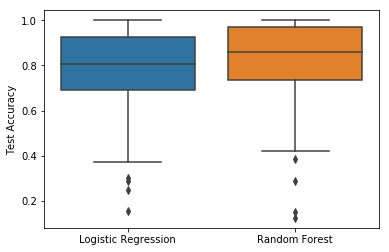

In [3]:
results = pd.DataFrame(pkl.load(open(oj(out_dir, 'classification_results.pkl'), 'rb')))

# plot
sns.boxplot(data=[results['logit_test_score'], results['rf_test_score']])
plt.xticks([0, 1], ['Logistic Regression', 'Random Forest'])
plt.ylabel('Test Accuracy')
plt.show()

# singlevar logistic vs logistic of curve

In [13]:
# right now assumes feat_nums is of length 1
def get_feats(X, feat_nums=[0]):
    if len(feat_nums) == 1:
        return X[:, feat_nums[0]].reshape(-1, 1)
    else:
        return X[:, feat_num]

def score_logistic_onevar(train_X, train_y, test_X, test_y, feat_nums, f):
    logit = LogisticRegression(solver='liblinear', multi_class='auto') # liblinear best for small dsets, otherwise lbfgs

    # full training
#     print('full logit score', row.logit_test_score)

    logit.fit(get_feats(train_X, feat_nums), train_y)
    logit_score_orig_onevar = logit.score(get_feats(test_X, feat_nums), test_y)

    logit.fit(f(get_feats(train_X, feat_nums)), train_y)
    logit_score_altered_onevar = logit.score(get_feats(f(test_X), feat_nums), test_y)
    
    return logit_score_orig_onevar, logit_score_altered_onevar    
    
'''
arg1 - trained forest
arg2 - X
arg3 - y
arg4 - S (array of size num_features, 0 to not use this variable otherwise 1)

returns: value of function on a line at regular intervals
'''
def single_var_grid_scores_and_plot(forest, X, y, S, curve_range=None, step=None, plot=True):
    # deal with params
    if curve_range is None:
        curve_range = (np.min(X), np.max(X))
    step = (curve_range[1] - curve_range[0]) / 100
    curve_range = (curve_range[0], curve_range[1] + step) # do this so we can interpolate properly
    
    
    models = forest.estimators_
    length = (curve_range[1] - curve_range[0]) / (1.0 * step)
    line = np.zeros(int(length))
    index = np.nonzero(S)[0][0]
    num_vars = len(S)
    for model in models:
        vals = interactions.traverse_all_paths(model, X, y, S, continuous_y=True)
        line += interactions.make_line(vals, curve_range, step, S)
    line = line/(len(models) * 1.0)
    x_axis = np.arange(curve_range[0], curve_range[1], step)
    
    if plot:
        fig, ax = plt.subplots()
        fig.set_size_inches(8, 6, forward=True)
        plt.plot(x_axis, line, 'k', c='b')
        plt.show()
    return x_axis, line

In [ ]:
# get dsets where rf outperforms logistic
idxs_mask = results['rf_test_score'] - results['logit_test_score'] > 0.1 
# r = results[idxs_mask]
r = results
print(results.shape, r.shape)
print('num idxs after filtering', np.sum(idxs_mask))
# idxs = np.arange(idxs_mask.size)[idxs_mask] # get actual indexes for this mask

score_results = {
        'feature_scores_mdi': [],
        'feature_scores_mda': [],
        'logit_score_orig_onevar_list': [],
        'logit_score_altered_onevar_list': [],
    }
for dset_num in tqdm(range(results.shape[0])): #tqdm(range(2)): #range(r.shape[0]):
    row = r.iloc[dset_num]    

    dset_name = row.dset_name # results['dset_names'][idx_0] #dsets.classification_dataset_names[0]
    X, y = dsets.fetch_data(dset_name, return_X_y=True, 
                      local_cache_dir=data_dir)
    train_X, test_X, train_y, test_y = train_test_split(X, y, random_state=random_state)
    num_features = X.shape[1]
    rf = row.rf
    assert(rf.score(test_X, test_y) == row.rf_test_score) # check that acc matches

    feature_scores_mdi = scores.get_importance_scores(rf, score_type='mdi', X=test_X, Y=test_y)
    feature_scores_mda = scores.get_importance_scores(rf, score_type='mda', X=test_X, Y=test_y)
#     feature_ranks = np.argsort(feature_scores)
#     print(f'feature_scores {feature_scores}\nfeature_ranks {feature_ranks}')

    score_results['feature_scores_mdi'].append(feature_scores_mdi)
    score_results['feature_scores_mda'].append(feature_scores_mda)


    logit_score_orig_onevar_list = []
    logit_score_altered_onevar_list = []
    for i in range(num_features):
        feat_nums = [i] # list of length 1 - longer lists not supported yet
        feat_vals = get_feats(X, feat_nums)
        feat_val_min = np.min(X)
        feat_val_max = np.max(X)
#         print(f'min {feat_val_min} max {feat_val_max}')

        # appropriate variable to get importance for
        S = np.zeros(num_features)
        S[feat_nums[0]]= 1

        x_axis, scores_on_spaced_line = single_var_grid_scores_and_plot(rf, train_X, train_y, S, (feat_val_min, feat_val_max), plot=False)
        f = interpolate.interp1d(x_axis, scores_on_spaced_line, kind='nearest') # function to interpolate the scores


        logit_score_orig_onevar, logit_score_altered_onevar = score_logistic_onevar(train_X, train_y, test_X, test_y, feat_nums, f)
        logit_score_orig_onevar_list.append(logit_score_orig_onevar)
        logit_score_altered_onevar_list.append(logit_score_altered_onevar)    

    score_results['logit_score_orig_onevar_list'].append(logit_score_orig_onevar_list)
    score_results['logit_score_altered_onevar_list'].append(logit_score_altered_onevar_list)
    
    
    # saving
    scores_df = pd.DataFrame(score_results)
    full_results = pd.concat([results.iloc[list(range(dset_num + 1))], scores_df], axis=1)
    pkl.dump(full_results, open(oj(out_dir, f'full_results_{dset_num}.pkl'), 'wb'))

  0%|          | 0/163 [00:00<?, ?it/s]

(163, 4) (163, 4)
num idxs after filtering 39


  4%|▍         | 7/163 [14:58<5:00:22, 115.53s/it]

# load scores results

In [33]:
full_results = pd.DataFrame(pkl.load(open(oj(out_dir, 'full_results_1.pkl'), 'rb')))

In [34]:
full_results

,logit_test_score,rf_test_score,dset_name,rf,feature_scores_mdi,feature_scores_mda,logit_score_orig_onevar_list,logit_score_altered_onevar_list
0,0.4925,0.535,GAMETES_Epistasis_2-Way_1000atts_0.4H_EDM-1_ED...,"(DecisionTreeClassifier(class_weight=None, cri...","[0.006933028720451824, 0.03603580130046279, 0....","[2.2204460492503132e-17, -0.003249999999999986...","[0.47, 0.5225, 0.52, 0.5075, 0.5, 0.525, 0.472...","[0.485, 0.485, 0.485, 0.485, 0.485, 0.485, 0.4..."
1,0.5050,0.570,GAMETES_Epistasis_2-Way_20atts_0.1H_EDM-1_1,"(DecisionTreeClassifier(class_weight=None, cri...","[0.06347856765994925, 0.04971802212164289, 0.0...","[0.025500000000000057, 0.006500000000000039, -...","[0.4575, 0.485, 0.485, 0.485, 0.4875, 0.5, 0.4...","[0.485, 0.485, 0.485, 0.485, 0.485, 0.485, 0.4..."
